## MorphL Challenge - Mihaela Nistor

The dataset is divided in 3 parts: users, sessions and hits. The users contain unique user ids and some basic user-level features. Then, the sessions represent each unique visit of the user to the website and we also have session-level features (browser used at that session, session duration etc.). Finally, we have hits, which can be interpreted as session-specific actions (such as what page was viewed). Basically, we have an embedded dataset: users > sessions > hits.

Our task is to model the user behaviour based on its history in order to predict a user-level feature (segment). Obviously, this is a very open-ended problem, with solutions varying from the simplest models (as those in prerequisites) to much more complex models (such as modeling hits and sessions with RNNs).

In [1]:
# !sudo pip install imbalanced-learn

Import everything

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Set this variable to True or False to use or not the smote technique

In [3]:
apply_smote = True

Read the dataset

In [4]:
# train_users = pd.read_csv('./train_set/users.csv')
# train_sessions = pd.read_csv('./train_set/sessions.csv')
# train_hits = pd.read_csv('./train_set/hits.csv')

# train_targets = pd.read_csv('./train_set/targets.csv')


# test_users = pd.read_csv('./test_set/users.csv')
# test_sessions = pd.read_csv('./test_set/sessions.csv')
# test_hits = pd.read_csv('./test_set/hits.csv')

# test_targets = pd.read_csv('./test_set/targets.csv')

In [5]:
from google.colab import drive
drive.mount('/content/drive')


root_folder = '/content/drive/MyDrive/Colab Notebooks/dataset_morphl/'

train_users = pd.read_csv(root_folder + 'train_set/users.csv')
train_sessions = pd.read_csv(root_folder + 'train_set/sessions.csv')
train_hits = pd.read_csv(root_folder + 'train_set/hits.csv')

train_targets = pd.read_csv(root_folder + 'train_set/targets.csv')


test_users = pd.read_csv(root_folder + 'test_set/users.csv')
test_sessions = pd.read_csv(root_folder + 'test_set/sessions.csv')
test_hits = pd.read_csv(root_folder + 'test_set/hits.csv')

test_targets = pd.read_csv(root_folder + 'test_set/targets.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(train_users.shape)
train_users.head()

(11200, 4)


,Unnamed: 0,Client ID,Total Number of Sessions,Type
0,0,ML10669446,3,1
1,1,ML1054774,20,2
2,2,ML1023632,17,2
3,3,ML1050999,1,2
4,4,ML10421332,11,1


In [7]:
train_sessions.head()

,Unnamed: 0,Unnamed: 0.1,Client ID,Session ID,Session Index,Session Duration,Transactions,Revenue,Site Search Status,Search Result Page Hits,Unique Pageviews,Shopping Stages,Device Category,City Name,Country,Browser Name,Device Name,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches
0,0,0,ML1000002,1587635093.120043981.1559843616.20200423,1,164,0,0.0,Visit Without Site Search,0,3,0,desktop,City-151,Country-50,Browser-46,Device-0,0,0.0,0,0,0
1,1,1,ML10000104,1577964914.1347073935.1554187261.20200102,1,353,0,0.0,Visit Without Site Search,0,6,0,mobile,City-907,Country-50,Browser-4,Device-217,0,0.0,0,0,0
2,2,2,ML10000104,1577984613.1347073935.1554187261.20200102,2,64,0,0.0,Visit Without Site Search,0,3,0,mobile,City-907,Country-50,Browser-4,Device-217,0,0.0,0,0,0
3,3,3,ML10000104,1577997594.1347073935.1554187261.20200102,3,4,0,0.0,Visit Without Site Search,0,2,0,mobile,City-907,Country-50,Browser-4,Device-217,0,0.0,0,0,0
4,4,4,ML10000104,1580645789.1861233595.1580645788.20200202,4,45,0,0.0,Visit Without Site Search,0,5,0,mobile,City-135,Country-50,Browser-4,Device-502,0,0.0,30,0,0


In [8]:
train_hits.head()

,Unnamed: 0,Client ID,Session ID,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,Path of Page
0,0,ML1000002,1587635093.120043981.1559843616.20200423,2,19106,202004230945,0,URL-1327
1,1,ML1000002,1587635093.120043981.1559843616.20200423,3,164167,202004230947,0,URL-1351
2,2,ML1000002,1587635093.120043981.1559843616.20200423,1,0,202004230944,0,URL-14663
3,3,ML10000104,1580645789.1861233595.1580645788.20200202,4,16274,202002021216,0,URL-9880
4,4,ML10000104,1577984613.1347073935.1554187261.20200102,1,0,202001021703,0,URL-14320


In [9]:
train_targets.head()

,Unnamed: 0,Client ID,segment
0,0,ML73020059,1
1,1,ML10396280,0
2,2,ML1017227,0
3,3,ML10230015,0
4,4,ML73768914,1


In [10]:
train_users = train_users.drop(['Unnamed: 0'], axis=1)
test_users = test_users.drop(['Unnamed: 0'], axis=1)
train_sessions = train_sessions.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
test_sessions = test_sessions.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
train_hits = train_hits.drop(['Unnamed: 0'], axis=1)
test_hits = test_hits.drop(['Unnamed: 0'], axis=1)
train_targets = train_targets.drop(['Unnamed: 0'], axis=1)
test_targets = test_targets.drop(['Unnamed: 0'], axis=1)

Create dataset function that append the hits mean/meadian to the the session and the sessions mean/median to the client(user)

In [11]:
def create_dataset(users, sessions, hits, targets, method="mean"):
    """
        Create one DataFrame from the users info: sessions, hits, segment
    """

    # group the hits by the session id
    if method == "mean":
        hits = hits.groupby(['Session ID'], as_index=False).mean()
    else:
        hits = hits.groupby(['Session ID'], as_index=False).median()

    # add the hits to their session
    sessions  = sessions.join(hits.set_index('Session ID'), on='Session ID', lsuffix='_session', rsuffix='_hit')

    # group the sessions by the client id
    if method == "mean":
        sessions = sessions.groupby(['Client ID'], as_index=False).mean()
    else:
        sessions = sessions.groupby(['Client ID'], as_index=False).median()

    # add the sessions to their client
    users  = users.join(sessions.set_index('Client ID'), on='Client ID', lsuffix='_user', rsuffix='_session')

    # add the targets to their client
    users  = users.join(targets.set_index('Client ID'), on='Client ID', lsuffix='_user', rsuffix='_target')

    return users

In [12]:
train_data = create_dataset(train_users, train_sessions, train_hits, train_targets)
test_data = create_dataset(test_users, test_sessions, test_hits, test_targets)

print(train_data.shape)
print(test_data.shape)

(11200, 19)
(1000, 19)


In [13]:
train_data.head()

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,segment
0,ML10669446,3,1,1.5,248.500000,0.0,0.0,0.000000,5.500000,0.0,0.000000,53.500000,0.000000,0.000000,7.500000,47624.229167,2.020041e+11,0.00,0
1,ML1054774,20,2,9.5,830.388889,0.0,0.0,0.000000,5.444444,0.0,0.000000,2.944444,0.000000,0.000000,6.111111,427477.318289,2.020051e+11,0.00,0
2,ML1023632,17,2,15.5,206.033333,0.0,0.0,0.000000,3.400000,0.0,0.000000,5.333333,0.000000,0.000000,4.250000,96655.143718,2.020035e+11,0.01,0
3,ML1050999,1,2,7.0,614.000000,0.0,0.0,0.076923,3.846154,0.0,0.307692,7.076923,0.076923,0.076923,4.192308,252253.695688,2.020044e+11,0.00,0
4,ML10421332,11,1,2.0,20.000000,0.0,0.0,0.000000,1.333333,0.0,0.000000,3.000000,0.000000,0.000000,1.833333,11109.333333,2.020021e+11,0.00,0


Use LabelEncoder to transform the 'Client ID' string to float value

In [14]:
le = LabelEncoder()
le.fit(pd.concat([train_data['Client ID'], test_data['Client ID']]).astype(str))
train_data['Client ID'] = le.transform(train_data['Client ID'].astype(str))
test_data['Client ID'] = le.transform(test_data['Client ID'].astype(str))
train_data.dtypes

Client ID                     int64
Total Number of Sessions      int64
Type                          int64
Session Index               float64
Session Duration            float64
Transactions                float64
Revenue                     float64
Search Result Page Hits     float64
Unique Pageviews            float64
Search Refinements          float64
Search Depth                float64
Days Since Last Session     float64
Results Pageviews           float64
Total Unique Searches       float64
Hit Index                   float64
Hit Time                    float64
Date Hour and Minute        float64
Product Detail Views        float64
segment                       int64
dtype: object

Count if all values are finite

In [15]:
np.isfinite(train_data).sum()

Client ID                   11200
Total Number of Sessions    11200
Type                        11200
Session Index               11192
Session Duration            11192
Transactions                11192
Revenue                     11192
Search Result Page Hits     11192
Unique Pageviews            11192
Search Refinements          11192
Search Depth                11192
Days Since Last Session     11192
Results Pageviews           11192
Total Unique Searches       11192
Hit Index                   11192
Hit Time                    11192
Date Hour and Minute        11192
Product Detail Views        11192
segment                     11200
dtype: int64

Replace infinite values with Nan

In [16]:
# replace inf with nan
train_data.replace([np.inf, -np.inf], np.nan)
test_data.replace([np.inf, -np.inf], np.nan)

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,segment
0,7802,1,2,8.5,285.187500,0.0,0.0,0.000000,4.000000,0.000000,0.000000,10.437500,0.000000,0.000000,4.562500,8.321651e+04,2.020038e+11,0.012931,0.5
1,2263,3,2,33.5,562.651515,0.0,0.0,0.075758,1.818182,0.015152,0.151515,2.363636,0.045455,0.045455,2.856061,2.803967e+05,2.020038e+11,0.036105,0.5
2,6572,1,2,8.0,326.133333,0.0,0.0,0.000000,3.200000,0.000000,0.000000,7.733333,0.000000,0.000000,6.666667,1.517154e+05,2.020045e+11,0.087637,0.5
3,2523,19,2,16.5,415.656250,0.0,0.0,0.750000,4.750000,0.125000,1.093750,4.718750,0.406250,0.312500,4.750000,2.267386e+05,2.020042e+11,0.009868,0.5
4,6765,37,1,2.5,336.500000,0.0,0.0,0.000000,6.250000,0.000000,0.000000,36.250000,0.000000,0.000000,3.875000,5.621226e+04,2.020036e+11,0.000000,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8062,1,9,1.0,3787.000000,0.0,0.0,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,2.144218e+06,2.020033e+11,0.000000,0.5
996,584,25,2,2.0,420.666667,0.0,0.0,0.000000,3.333333,0.000000,0.000000,24.000000,0.000000,0.000000,5.000000,1.063912e+05,2.020045e+11,0.000000,0.5
997,8791,8,9,2.5,86.000000,0.0,0.0,0.250000,2.750000,0.000000,0.000000,17.000000,0.000000,0.000000,2.250000,4.147883e+04,2.020049e+11,0.000000,0.5
998,3573,2,1,1.5,257.500000,0.0,0.0,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,4.750000,1.356443e+05,2.020033e+11,0.000000,0.5


Count nan values

In [17]:
train_data.isna().sum()

Client ID                   0
Total Number of Sessions    0
Type                        0
Session Index               8
Session Duration            8
Transactions                8
Revenue                     8
Search Result Page Hits     8
Unique Pageviews            8
Search Refinements          8
Search Depth                8
Days Since Last Session     8
Results Pageviews           8
Total Unique Searches       8
Hit Index                   8
Hit Time                    8
Date Hour and Minute        8
Product Detail Views        8
segment                     0
dtype: int64

Remove data with nan values

In [18]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

train_data.isna().sum()

Client ID                   0
Total Number of Sessions    0
Type                        0
Session Index               0
Session Duration            0
Transactions                0
Revenue                     0
Search Result Page Hits     0
Unique Pageviews            0
Search Refinements          0
Search Depth                0
Days Since Last Session     0
Results Pageviews           0
Total Unique Searches       0
Hit Index                   0
Hit Time                    0
Date Hour and Minute        0
Product Detail Views        0
segment                     0
dtype: int64

In [19]:
test_data.isna().sum()

Client ID                   0
Total Number of Sessions    0
Type                        0
Session Index               0
Session Duration            0
Transactions                0
Revenue                     0
Search Result Page Hits     0
Unique Pageviews            0
Search Refinements          0
Search Depth                0
Days Since Last Session     0
Results Pageviews           0
Total Unique Searches       0
Hit Index                   0
Hit Time                    0
Date Hour and Minute        0
Product Detail Views        0
segment                     0
dtype: int64

See columns types

In [20]:
train_data.dtypes

Client ID                     int64
Total Number of Sessions      int64
Type                          int64
Session Index               float64
Session Duration            float64
Transactions                float64
Revenue                     float64
Search Result Page Hits     float64
Unique Pageviews            float64
Search Refinements          float64
Search Depth                float64
Days Since Last Session     float64
Results Pageviews           float64
Total Unique Searches       float64
Hit Index                   float64
Hit Time                    float64
Date Hour and Minute        float64
Product Detail Views        float64
segment                       int64
dtype: object

In [21]:
train_data.head()

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,segment
0,8625,3,1,1.5,248.500000,0.0,0.0,0.000000,5.500000,0.0,0.000000,53.500000,0.000000,0.000000,7.500000,47624.229167,2.020041e+11,0.00,0
1,7061,20,2,9.5,830.388889,0.0,0.0,0.000000,5.444444,0.0,0.000000,2.944444,0.000000,0.000000,6.111111,427477.318289,2.020051e+11,0.00,0
2,3417,17,2,15.5,206.033333,0.0,0.0,0.000000,3.400000,0.0,0.000000,5.333333,0.000000,0.000000,4.250000,96655.143718,2.020035e+11,0.01,0
3,6629,1,2,7.0,614.000000,0.0,0.0,0.076923,3.846154,0.0,0.307692,7.076923,0.076923,0.076923,4.192308,252253.695688,2.020044e+11,0.00,0
4,5657,11,1,2.0,20.000000,0.0,0.0,0.000000,1.333333,0.0,0.000000,3.000000,0.000000,0.000000,1.833333,11109.333333,2.020021e+11,0.00,0


In [22]:
test_data.head()

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views,segment
0,7802,1,2,8.5,285.187500,0.0,0.0,0.000000,4.000000,0.000000,0.000000,10.437500,0.000000,0.000000,4.562500,83216.512552,2.020038e+11,0.012931,0.5
1,2263,3,2,33.5,562.651515,0.0,0.0,0.075758,1.818182,0.015152,0.151515,2.363636,0.045455,0.045455,2.856061,280396.683224,2.020038e+11,0.036105,0.5
2,6572,1,2,8.0,326.133333,0.0,0.0,0.000000,3.200000,0.000000,0.000000,7.733333,0.000000,0.000000,6.666667,151715.383549,2.020045e+11,0.087637,0.5
3,2523,19,2,16.5,415.656250,0.0,0.0,0.750000,4.750000,0.125000,1.093750,4.718750,0.406250,0.312500,4.750000,226738.635647,2.020042e+11,0.009868,0.5
4,6765,37,1,2.5,336.500000,0.0,0.0,0.000000,6.250000,0.000000,0.000000,36.250000,0.000000,0.000000,3.875000,56212.258929,2.020036e+11,0.000000,0.5


Split the target from the user data

In [23]:
train_y = train_data['segment']
train_X = train_data.drop(['segment'], axis=1)

test_y = test_data['segment']
test_X = test_data.drop(['segment'], axis=1)


Normalize the data excepting the 'Client ID', because we need it to identify the client predicted segment

In [24]:

min_max_scaler = MinMaxScaler()

columns = []
for col in list(test_X.columns):
  if col != "Client ID":
    columns.append(col)

test_X.loc[:, columns] = min_max_scaler.fit_transform(test_X[columns])
train_X.loc[:, columns] = min_max_scaler.fit_transform(train_X[columns])


In [25]:
train_X.head()

,Client ID,Total Number of Sessions,Type,Session Index,Session Duration,Transactions,Revenue,Search Result Page Hits,Unique Pageviews,Search Refinements,Search Depth,Days Since Last Session,Results Pageviews,Total Unique Searches,Hit Index,Hit Time,Date Hour and Minute,Product Detail Views
0,8625,0.000398,0.000,0.001815,0.032686,0.0,0.0,0.000000,0.133663,0.0,0.000000,0.604520,0.000000,0.000000,0.035036,0.014387,0.969579,0.000000
1,7061,0.003777,0.125,0.030853,0.109534,0.0,0.0,0.000000,0.132013,0.0,0.000000,0.033271,0.000000,0.000000,0.026926,0.129755,0.980122,0.000000
2,3417,0.003181,0.125,0.052632,0.027078,0.0,0.0,0.000000,0.071287,0.0,0.000000,0.060264,0.000000,0.000000,0.016058,0.029279,0.962415,0.009524
3,6629,0.000000,0.125,0.021779,0.080956,0.0,0.0,0.005044,0.084539,0.0,0.008791,0.079965,0.009324,0.021978,0.015722,0.076537,0.972072,0.000000
4,5657,0.001988,0.000,0.003630,0.002509,0.0,0.0,0.000000,0.009901,0.0,0.000000,0.033898,0.000000,0.000000,0.001946,0.003297,0.948210,0.000000


Split the train data in train and validation

In [26]:
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, random_state=17)

Count the client in every class (segment 0 / 1)

In [27]:
def plot_labels(train_y):
  plot_sb = sb.countplot(train_y, label='segment', palette="Set1")

  count_datapoints_in_classes = train_y.value_counts(sort=False)
  classes = list(set(train_y))
  for cls in classes:
    print('Class %d: %d' % (cls, count_datapoints_in_classes[cls]))

Class 0: 6278
Class 1: 2116


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


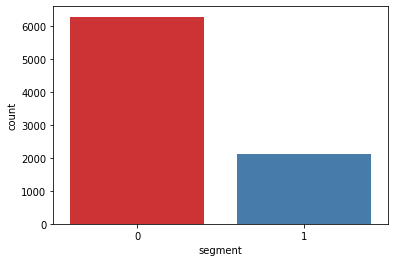

In [28]:
plot_labels(train_y)

Use SMOTE (Synthetic Minority Over-sampling TEchnique) to oversample the minority class 

In [29]:
if apply_smote:
  oversample = SMOTE()
  X_resampled, y_resampled = oversample.fit_resample(train_X, train_y)
  train_X = pd.DataFrame(X_resampled, columns=train_X.columns)
  train_y = pd.DataFrame(y_resampled, columns=['segment'])


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


See the number of values for every class after SMOTE

Class 0: 6278
Class 1: 6278


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


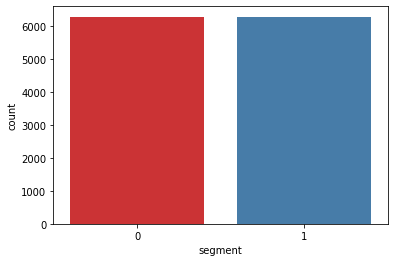

In [30]:
plot_labels(train_y['segment'])

Create a base class that will be used by every model

In [31]:
class Model:
  name = None
  model = None
  predictions = None
  predictions_probabilities = None
  top_features = None
  train_X = None
  train_y = None
  valid_X = None
  valid_y = None

  def __init__(self, model_name, train_X, train_y, valid_X=None, valid_y=None):
    self.name = model_name
    self.train_X = train_X
    self.train_y = train_y
    self.valid_X = valid_X
    self.valid_y = valid_y
    print("Creating the model (%s) ..." % self.name)

  def predict(self):
    print("Predict (%s) ..." % self.name)
    self.predictions = self.model.predict(self.valid_X)
    return self.predictions

  def predict_prob(self):
    print("Predict probabilities (%s) ..." % self.name)
    predictions = self.model.predict_proba(self.valid_X)
    self.predictions_probabilities = [i[1] for i in predictions]

    return self.predictions_probabilities

  def get_accuracy(self):
    if valid_y is None:
      raise ValueError("Validation labels are None") 
    if self.predictions is None:
      self.predict()
    return accuracy_score(self.valid_y, self.predictions)

  def get_loss(self):
    if valid_y is None:
      raise ValueError("Validation labels are None") 
    if self.predictions_probabilities is None:
      self.predict_prob()
    return log_loss(self.valid_y, self.predictions_probabilities)

  def plot_confusion_matrix(self):
    if valid_y is None:
      raise ValueError("Validation labels are None") 
    if self.predictions is None:
      self.predict()
    df_cm = confusion_matrix(self.valid_y, self.predictions)
    print(df_cm)
    df_cm = df_cm / df_cm.astype(np.float).sum(axis=1).sum()
    sb.heatmap(df_cm, annot=True)

  def get_top_features(self, top_n=10):

    if hasattr(self.model, 'feature_importances_'):
      feat_importances = pd.Series(self.model.feature_importances_, index=self.train_X.columns)
      feat_importances.nlargest(top_n).plot(kind='barh')
      plt.show()
      print(feat_importances.nlargest(top_n))

      self.top_features = list(feat_importances.nlargest(top_n).keys())
    else:
      self.top_features = []  

    return self.top_features

Logistic Regression class that initilize the model with the tuned parameters found with grid search

In [32]:
class LogisticRegressionModel(Model):

  def __init__(self, name, train_X, train_y, valid_X=None, valid_y=None):

    super().__init__(name, train_X, train_y, valid_X, valid_y)

    self.model = LogisticRegression(C=10, penalty='l2', solver='lbfgs')
    self.model.fit(self.train_X, self.train_y)


  def find_best(self):
    lr_model = LogisticRegression()

    param_grid = {
        'C': [0.1, 1.0, 10],
        'penalty': ['l2'],  # 'elasticnet', 'none', 'l1'
        'solver': ['lbfgs']  # 'newton-cg', 'liblinear', 'sag', 'saga
    }

    self.model = GridSearchCV(lr_model, param_grid, return_train_score=True, cv=5, n_jobs=-1)

    # Fit Grid Search Model
    self.model.fit(self.train_X, self.train_y)
    print("Best score: %0.3f" % self.model.best_score_)
    print("Best parameters set:")

    best_parameters = self.model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Multi-layer Perceptron class that initilize the model with the tuned parameters found with grid search

In [33]:
class MLPClassifierModel(Model):

  def __init__(self, name, train_X, train_y, valid_X=None, valid_y=None):

    super().__init__(name, train_X, train_y, valid_X, valid_y)

    self.model = MLPClassifier(activation='logistic',max_iter=900, solver='lbfgs')
    self.model.fit(self.train_X, self.train_y)

  def find_best(self):
    mlp_model = MLPClassifier()

    param_grid = {
        'solver': ['lbfgs', 'sgd', 'adam'],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'max_iter': range(200, 1000, 100)
    }

    self.model = GridSearchCV(mlp_model, param_grid, return_train_score=True, cv=5, n_jobs=-1)

    # Fit Grid Search Model
    self.model.fit(self.train_X, self.train_y)
    print("Best score: %0.3f" % self.model.best_score_)
    print("Best parameters set:")

    best_parameters = self.model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Extreme Gradient Boost class that initilize the model with the tuned parameters found with grid search

In [34]:
class XGBoostModel(Model):

  def __init__(self, name, train_X, train_y, valid_X=None, valid_y=None):

    super().__init__(name, train_X, train_y, valid_X, valid_y)

    self.model = XGBClassifier(colsample_bytree = 0.6, gamma = 0.5, max_depth = 4,
                               min_child_weight = 1, subsample = 1.0
                               )
    self.model.fit(self.train_X, self.train_y)

  def find_best(self):
    mlp_model = XGBClassifier()

    param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    self.model = GridSearchCV(mlp_model, param_grid, return_train_score=True, cv=5, n_jobs=-1)

    # Fit Grid Search Model
    self.model.fit(self.train_X, self.train_y)
    print("Best score: %0.3f" % self.model.best_score_)
    print("Best parameters set:")

    best_parameters = self.model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Random Forest class that initilize the model with the tuned parameters found with grid search

In [35]:
class RandomForestModel(Model):

  def __init__(self, name, train_X, train_y, valid_X=None, valid_y=None):

    super().__init__(name, train_X, train_y, valid_X, valid_y)

    self.model = RandomForestClassifier(max_features='auto', criterion='gini')
    self.model.fit(self.train_X, self.train_y)

  def find_best(self):
    rf = RandomForestClassifier()
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    self.model = GridSearchCV(rf, param_grid, return_train_score=True, cv=5, n_jobs=-1)
    # Fit Grid Search Model
    self.model.fit(self.train_X, self.train_y)
    print("Best score: %0.3f" % self.model.best_score_)
    print("Best parameters set:")

    best_parameters = self.model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


Support Vector Machine class

In [36]:
class SVMModel(Model):

  def __init__(self, name, train_X, train_y, valid_X=None, valid_y=None):

    super().__init__(name, train_X, train_y, valid_X, valid_y)

    self.model = SVC(probability=True)

    self.model.fit(self.train_X, self.train_y)

  def find_best(self):
    svm = SVC()
    param_grid = {
        'C': [C for C in [1, 15, 20]],
        'gamma': [gamma for gamma in ['auto']],
        'kernel': [kernel for kernel in ['linear', 'rbf']]
    }

    self.model = GridSearchCV(svm, param_grid, return_train_score=True, cv=5, n_jobs=-1)
    # Fit Grid Search Model
    self.model.fit(self.train_X, self.train_y)
    print("Best score: %0.3f" % self.model.best_score_)
    print("Best parameters set:")

    best_parameters = self.model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


Decision Tree class that initilize the model with the tuned parameters found with grid search

In [37]:
class DecisionTreeModel(Model):

  def __init__(self, name, train_X, train_y, valid_X=None, valid_y=None):

    super().__init__(name, train_X, train_y, valid_X, valid_y)

    self.model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1)

    self.model.fit(self.train_X, self.train_y)

  def find_best(self):
    dt = DecisionTreeClassifier()
    param_grid = {
        'criterion': ['entropy', 'gini'], 
        'max_depth': range(1, 20, 2)
    }

    self.model = GridSearchCV(dt, param_grid, return_train_score=True, cv=5, n_jobs=-1)
    # Fit Grid Search Model
    self.model.fit(self.train_X, self.train_y)
    print("Best score: %0.3f" % self.model.best_score_)
    print("Best parameters set:")

    best_parameters = self.model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


Factory class that returns the model based on a parameter 'name'

In [38]:
class ModelUtils:
  def __init__(self):
    pass

  @staticmethod
  def factory(name, train_X, train_y, valid_X=None, valid_y=None):

    if name == 'logistic_regression':
      return LogisticRegressionModel(name, train_X, train_y, valid_X, valid_y)
    if name == 'mlp_classifier':
      return MLPClassifierModel(name, train_X, train_y, valid_X, valid_y)
    if name == 'xgboost':
      return XGBoostModel(name, train_X, train_y, valid_X, valid_y)
    if name == 'random_forest':
      return RandomForestModel(name, train_X, train_y, valid_X, valid_y)
    if name == 'svm':
      return SVMModel(name, train_X, train_y, valid_X, valid_y)
    if name == 'decision_tree':
      return DecisionTreeModel(name, train_X, train_y, valid_X, valid_y)
    else:
        raise ValueError('Algorithm ' + name + ' is not supported')


Iterate trough a list of model names and find the best parameters if not already found. After this, predict the classes for the validation data and compute the loss and accuracy. If we can extract the most important features for that model, create a copy of the data set with the most important features and compute the loss and accuracy for that mdel too.




******************************  logistic_regression  ******************************

Creating the model (logistic_regression) ...
Predict (logistic_regression) ...
Predict probabilities (logistic_regression) ...
logistic_regression	accuracy_score: 0.990 
logistic_regression	log loss: 0.065 



******************************  mlp_classifier  ******************************

Creating the model (mlp_classifier) ...
Predict (mlp_classifier) ...
Predict probabilities (mlp_classifier) ...
mlp_classifier	accuracy_score: 0.990 
mlp_classifier	log loss: 0.058 



******************************  xgboost  ******************************

Creating the model (xgboost) ...
Predict (xgboost) ...
Predict probabilities (xgboost) ...
xgboost	accuracy_score: 0.998 
xgboost	log loss: 0.010 


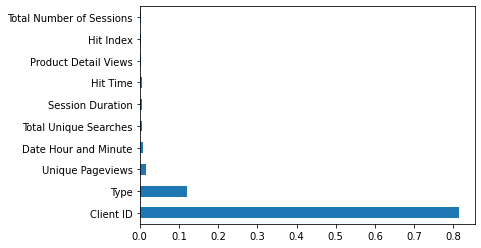

Client ID                   0.813018
Type                        0.120937
Unique Pageviews            0.015717
Date Hour and Minute        0.009011
Total Unique Searches       0.007000
Session Duration            0.006897
Hit Time                    0.004655
Product Detail Views        0.004155
Hit Index                   0.004125
Total Number of Sessions    0.004069
dtype: float32



******************************  xgboost_top_features  ******************************

Creating the model (xgboost) ...
Predict (xgboost) ...
xgboost_top_features	accuracy_score: 0.998 
Predict probabilities (xgboost) ...
xgboost_top_features	log loss: 0.009 



******************************  random_forest  ******************************

Creating the model (random_forest) ...
Predict (random_forest) ...
Predict probabilities (random_forest) ...
random_forest	accuracy_score: 0.998 
random_forest	log loss: 0.019 


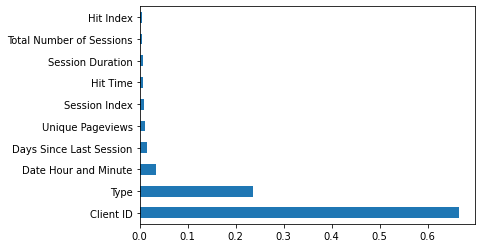

Client ID                   0.664701
Type                        0.235370
Date Hour and Minute        0.033478
Days Since Last Session     0.014704
Unique Pageviews            0.012008
Session Index               0.009706
Hit Time                    0.007287
Session Duration            0.006855
Total Number of Sessions    0.005154
Hit Index                   0.004257
dtype: float64



******************************  random_forest_top_features  ******************************

Creating the model (random_forest) ...
Predict (random_forest) ...
random_forest_top_features	accuracy_score: 0.998 
Predict probabilities (random_forest) ...
random_forest_top_features	log loss: 0.023 



******************************  svm  ******************************

Creating the model (svm) ...
Predict (svm) ...
Predict probabilities (svm) ...
svm	accuracy_score: 0.984 
svm	log loss: 0.040 



******************************  decision_tree  ******************************

Creating the model (decision_tree) .

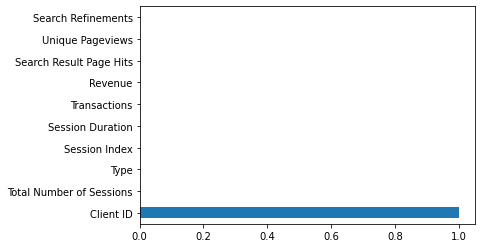

Client ID                   1.0
Total Number of Sessions    0.0
Type                        0.0
Session Index               0.0
Session Duration            0.0
Transactions                0.0
Revenue                     0.0
Search Result Page Hits     0.0
Unique Pageviews            0.0
Search Refinements          0.0
dtype: float64



******************************  decision_tree_top_features  ******************************

Creating the model (decision_tree) ...
Predict (decision_tree) ...
decision_tree_top_features	accuracy_score: 0.998 
Predict probabilities (decision_tree) ...
decision_tree_top_features	log loss: 0.013 


In [39]:
models_name = [
               "logistic_regression",
               "mlp_classifier",
               "xgboost",
               "random_forest",
               "svm",
               "decision_tree"
]

titles = []
losses = []
accuracies = []
for model_name in models_name:
  print("\n\n\n******************************  %s  ******************************\n" % str(model_name))
  model = ModelUtils.factory(model_name, train_X, train_y.values.ravel(), valid_X, valid_y.values.ravel())
  # model.find_best()
  model.predict()
  accuracy = model.get_accuracy()
  loss = model.get_loss()
  print("%s\taccuracy_score: %0.3f " % (model_name, accuracy))
  print("%s\tlog loss: %0.3f " % (model_name, loss))
  # model.plot_confusion_matrix()

  titles.append(model_name)
  losses.append(loss)
  accuracies.append(accuracy)

  model.get_top_features()
  if model.top_features is not None and len(model.top_features) > 0:
    print("\n\n\n******************************  %s  ******************************\n" % str(model_name + "_top_features"))

    _train_X = train_X.copy()
    _valid_X = valid_X.copy()

    for column in train_X.columns:
      if column not in model.top_features:
        _train_X = _train_X.drop([column], axis=1)
        _valid_X = _valid_X.drop([column], axis=1)

    model = ModelUtils.factory(model_name, _train_X, train_y.values.ravel(), _valid_X, valid_y.values.ravel())
    print("%s\taccuracy_score: %0.3f " % (model_name + "_top_features", model.get_accuracy()))
    print("%s\tlog loss: %0.3f " % (model_name + "_top_features", model.get_loss()))
    titles.append(model_name + "_top_features")
    losses.append(model.get_loss())
    accuracies.append(model.get_accuracy())



In [47]:
for i in range(len(titles)):
  tab = " " * (30 - len(titles[i]))
  print("model: %s %s accuracy: %s \t\t loss: %s" % (titles[i], tab, str(accuracies[i]), str(losses[i])))

model: logistic_regression             accuracy: 0.9899928520371694 		 loss: 0.06490033136347419
model: mlp_classifier                  accuracy: 0.9899928520371694 		 loss: 0.05798024998849183
model: xgboost                         accuracy: 0.9982130092923517 		 loss: 0.010218853989738859
model: xgboost_top_features            accuracy: 0.9982130092923517 		 loss: 0.009347932362408322
model: random_forest                   accuracy: 0.9982130092923517 		 loss: 0.018804464818339226
model: random_forest_top_features      accuracy: 0.9982130092923517 		 loss: 0.02297162685913253
model: svm                             accuracy: 0.9835596854896355 		 loss: 0.040036862699667816
model: decision_tree                   accuracy: 0.9982130092923517 		 loss: 0.012746978200795124
model: decision_tree_top_features      accuracy: 0.9982130092923517 		 loss: 0.012746978200795124


Plot the loss for every model

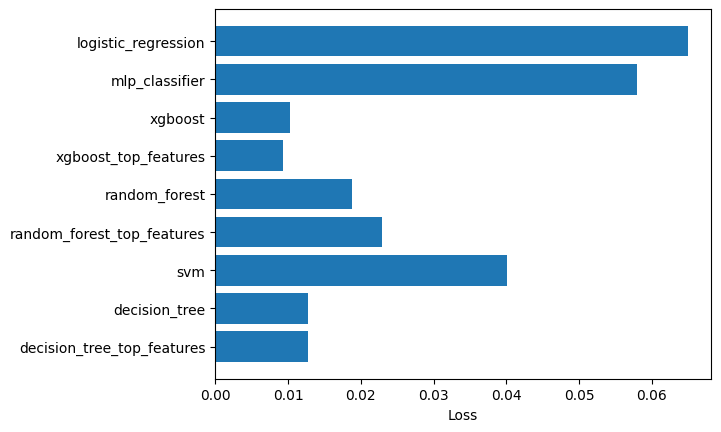

In [41]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(titles))

ax.barh(y_pos, losses, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(titles)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Loss')

plt.show()

Predict the segment for the test value

In [42]:
# predictions = model.predict_proba(test_X)
# predictions = [i[1] for i in predictions]
# print(predictions)


Save the predictions

In [43]:
# test_X['segment'] = predictions
# test_targets = test_targets.drop(['segment'], axis=1)
# test_X['Client ID'] = le.inverse_transform(test_X['Client ID'])

# test_targets = pd.merge(test_targets,test_X[['Client ID','segment']],on='Client ID') 
# test_targets.to_csv(index=False, path_or_buf=root_folder +'results.csv')